# <font color='lightblue'>Computer Vision</font>

En este notebook veremos como implementar una arquitectura de red para procesar imágenes y que aprenda a obtener patrones (pixeles) que le sirvan para hacer una clasificación.

Usaremos el dataset [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) para distintas tareas. Espero que no les de hambre xd.

Veremos:
1. Clasificación binaria (sigmoid).
2. Clasificación multi-clase (softmax/argmax).
3. Transfer Learning.

## 1. Clasificación binaria de imágenes

Primero cargamos el dataset que contiene solo imágenes de pizzas y steaks(carne) para entrenar una red neuronal convolucional para clasificación binaria.



### Cargamos el dataset

In [76]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-10-18 18:55:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  69.3MB/s    in 1.5s    

2023-10-18 18:55:16 (69.3 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



In [77]:
!nvidia-smi

Wed Oct 18 18:55:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |   9071MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

>**Nota:** La estructura de carpetas bajo el nombre de train o test y luego bajo el nombre de pizza o steak en cada caso, es el tipo de estructura que necesita `TensorFlow` para saber cual es la carpeta de entrenamiento y testeo, y cual es la clase (etiqueta) de cada grupo de imagen. Con esta clase que encuentra en el nombre de la carpeta es la que va a utilizar para entrenarse.

In [79]:
import os
os.listdir('pizza_steak/test/pizza')

['140016.jpg',
 '80750.jpg',
 '296426.jpg',
 '573054.jpg',
 '3581181.jpg',
 '849291.jpg',
 '2719697.jpg',
 '1180273.jpg',
 '248199.jpg',
 '139952.jpg',
 '1555015.jpg',
 '3784357.jpg',
 '2101820.jpg',
 '3729167.jpg',
 '2003290.jpg',
 '2276783.jpg',
 '2082495.jpg',
 '419962.jpg',
 '1925494.jpg',
 '2615100.jpg',
 '614236.jpg',
 '103708.jpg',
 '1636919.jpg',
 '3392194.jpg',
 '3042459.jpg',
 '3385460.jpg',
 '61656.jpg',
 '2521769.jpg',
 '1342321.jpg',
 '2841536.jpg',
 '226472.jpg',
 '2583389.jpg',
 '2508316.jpg',
 '415551.jpg',
 '418251.jpg',
 '447914.jpg',
 '2236338.jpg',
 '144631.jpg',
 '194784.jpg',
 '2619955.jpg',
 '1594097.jpg',
 '1949644.jpg',
 '1687143.jpg',
 '309892.jpg',
 '1980749.jpg',
 '3375083.jpg',
 '2392727.jpg',
 '1220156.jpg',
 '1503858.jpg',
 '1228171.jpg',
 '3669673.jpg',
 '930553.jpg',
 '1315645.jpg',
 '1412011.jpg',
 '3724416.jpg',
 '2543207.jpg',
 '1691503.jpg',
 '2161321.jpg',
 '1032754.jpg',
 '2111981.jpg',
 '3586083.jpg',
 '2549661.jpg',
 '1445608.jpg',
 '645087.jpg'

In [80]:
# Exploramos las carpetas un poco...
import os

for dir, dirname, files in os.walk('pizza_steak'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: pizza_steak | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: pizza_steak/train | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/train/steak | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/test | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/test/pizza | subdir: [] | cant de imagenes: 250 
Dir: pizza_steak/test/steak | subdir: [] | cant de imagenes: 250 


Vemos que la carpeta `train` contiene 750 imágenes de pizza y 750 de steak.

La carpeta `test` contiene 250 imágenes de pizza y 250 imágenes de steak.

In [81]:
#Guardamos el nombre de las carpetas que haya dentro de train en una lista
# se puede hacer a mano pero a veces son muchas y podemos cometer errores.

classes = [f for f in os.listdir('pizza_steak/train/')]
print(classes)

['pizza', 'steak']


### Visualizamos algunos ejemplos del dataset

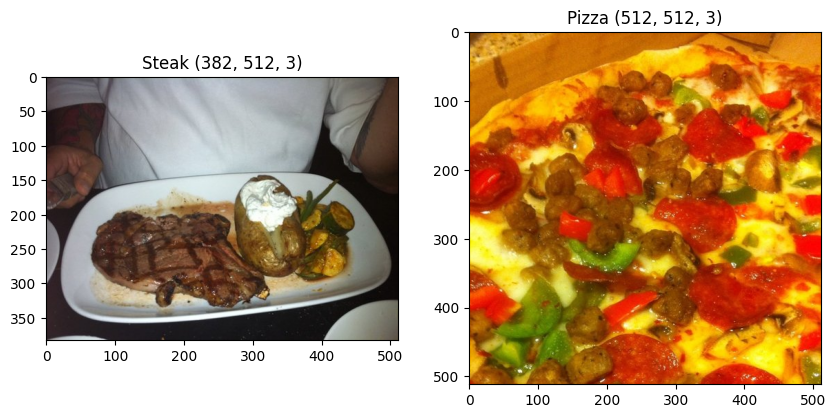

In [82]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,7))
id = random.choice(range(0,749))
plt.subplot(1,2,1)
img_name = [f for f in os.listdir('pizza_steak/train/steak/')][id]
img = plt.imread('pizza_steak/train/steak/'+img_name)
plt.imshow(img)
plt.title('Steak '+str(img.shape))
plt.subplot(1,2,2)
img_name = [f for f in os.listdir('pizza_steak/train/pizza/')][id]
img = plt.imread('pizza_steak/train/pizza/'+img_name)
plt.imshow(img)
plt.title('Pizza '+str(img.shape));

In [83]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('pizza_steak/train/pizza/')]
imagen_prueba = plt.imread('pizza_steak/train/pizza/'+lista_img_pizza[23]) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (384, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


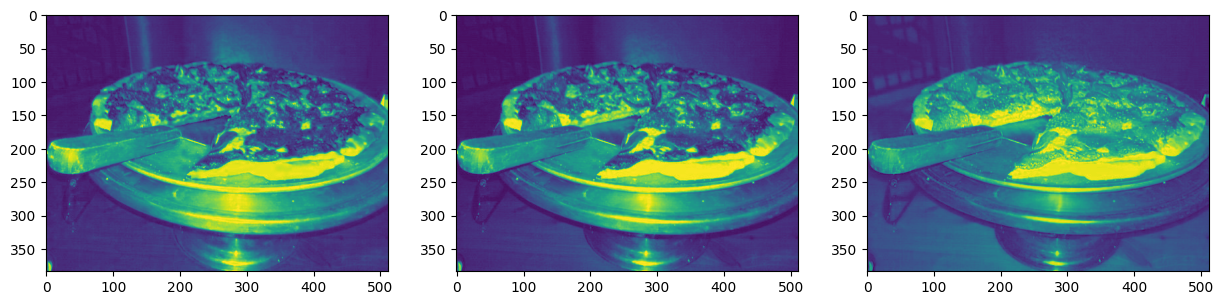

In [84]:
import cv2
imagen_prueba = cv2.imread('pizza_steak/train/pizza/'+lista_img_pizza[22])
b,g,r =  cv2.split(imagen_prueba)
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(b,cmap=None)
plt.subplot(1,3,2)
plt.imshow(g,cmap=None)
plt.subplot(1,3,3)
plt.imshow(r,cmap=None);

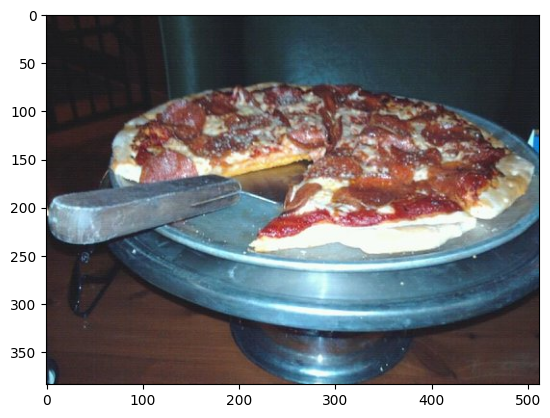

In [85]:
imagen_reconstruida = cv2.merge([r,g,b])
plt.imshow(imagen_reconstruida);

### Creamos la arquitectura de una red neuronal convolucional
Vamos a construir una red neuronal convolucional para encontrar patrones en nuestras imágenes, más específicamente, necesitamos una forma de:
* Cargar la imágenes con TensorFlow
* Preprocesar las imágenes para escalarlas.
* Construir la red convolucional para clasificación
* Compilar la CNN
* Entrenar la CNN con los datos de entrenamiento.

In [86]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary') #multiclass -> 'categorical' [001,100,010]
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [87]:
imagenes, etiquetas = train_batch[0]
print(len(imagenes),len(etiquetas))

32 32


In [88]:
classes

['pizza', 'steak']

In [89]:
etiquetas

array([1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

In [90]:
import tensorflow as tf
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=((224,224,3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 150528)            0         
                                                                 
 dense_28 (Dense)            (None, 256)               38535424  
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 38634241 (147.38 MB)
Trainable params: 38634241 (147.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Observamos que la cantidad de parámetros en una red fully connected, con solo capas profundas para entrenar con imágenes, resulta muy grande. Y con esto crece la necesidad de poder de computo a la vez que la red tiene que aprender pixel a pixel, lo cual lleva mucho más tiempo.

Una solución a esto es incorporar capas de filtrado, que filtren solo aquella información de la imagen que la red "crea" que es importante. Con esto la cantidad de parámetros se reduce a solo los parametros de dichos filtros, que resultan en menor cantidad y tiempo de procesamiento.

In [91]:
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.20)),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_215 (Conv2D)         (None, 222, 222, 5)       140       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 5)       0         
 ng2D)                                                           
                                                                 
 conv2d_216 (Conv2D)         (None, 109, 109, 5)       230       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 5)         0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 5)         0         
                                                                 
 conv2d_217 (Conv2D)         (None, 52, 52, 5)       

In [92]:
## Compilamos el modelo
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
## Entrenamos el modelo
model_0.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
47/47 [==============================] - 9s 138ms/step - loss: 0.6270 - accuracy: 0.6427 - precision_7: 0.6602 - recall_7: 0.5880 - val_loss: 0.5436 - val_accuracy: 0.7160 - val_precision_7: 0.6942 - val_recall_7: 0.7720
Epoch 2/100
47/47 [==============================] - 7s 148ms/step - loss: 0.5642 - accuracy: 0.7247 - precision_7: 0.7604 - recall_7: 0.6560 - val_loss: 0.5125 - val_accuracy: 0.7640 - val_precision_7: 0.8028 - val_recall_7: 0.7000
Epoch 3/100
47/47 [==============================] - 5s 115ms/step - loss: 0.5649 - accuracy: 0.7213 - precision_7: 0.7485 - recall_7: 0.6667 - val_loss: 0.5523 - val_accuracy: 0.7120 - val_precision_7: 0.9274 - val_recall_7: 0.4600
Epoch 4/100
47/47 [==============================] - 7s 151ms/step - loss: 0.5265 - accuracy: 0.7460 - precision_7: 0.7843 - recall_7: 0.6787 - val_loss: 0.4922 - val_accuracy: 0.7740 - val_precision_7: 0.8870 - val_recall_7: 0.6280
Epoch 5/100
47/47 [==============================] - 6s 124ms/step -

### Evaluamos el modelo

Para esto vamos a importarlo de la carpeta donde se guardaron los checkpoints.

In [93]:
model_0 = tf.keras.models.load_model('/content/checkpoints/model_0')

In [94]:
model_0.evaluate(test_batch)

16/16 [==============================] - 1s 77ms/step - loss: 0.2702 - accuracy: 0.8760 - precision_7: 0.8950 - recall_7: 0.8520


[0.27015212178230286,
 0.8759999871253967,
 0.894957959651947,
 0.8519999980926514]

In [95]:
# Podemos ver las métricas con TensorBoard que guardamos durante el entrenamiento
!tensorboard dev upload --logdir=logs/model_0  #tensorboard --logdir=

2023-10-18 19:10:12.559408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.p

### Hacemos una predicción

In [96]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

1/1 [==============================] - 0s 79ms/step
[[0.00678812]]


In [97]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

La predicción para la imagen de pizza es: 0.0 


In [98]:
classes

['pizza', 'steak']

# Ejercicio 1

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,64)
2. El tamaño del kernel de los filtros también puede crecer 7x7, 9x7, 11x11.
3. Podemos implementar data augmentation.
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

## Tecnicas de Data Augmentation

In [99]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(10) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,#Data augmentation
                                                                  vertical_flip=True)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 horizontal_flip=True,#Data augmentation
                                                                 vertical_flip=True)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary') #multiclass -> 'categorical' [001,100,010]

test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Red convolucional

In [100]:
model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=((224,224,3))),
    tf.keras.layers.Flatten(),# vectorizacion de las imágenes
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 150528)            0         
                                                                 
 dense_34 (Dense)            (None, 256)               38535424  
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 38634241 (147.38 MB)
Trainable params: 38634241 (147.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Observamos que de nuevo que la cantidad de parametros en una red fully connected, con solo capas profundas para entrenar con imagenes, resulta muy grande, lo que hace que crezca la necesidad de poder de computo a la vez que la red tiene que aprender pixel a pixel. Esto se resume a que lleva mucho mas tiempo.

Ahora lo que hacemos es incorporar capas de filtrado, que filtren la informacion de la imagen que la red considere importante.

En esta parte, aumentamos los filtros de las capas convulacionales, asi como tambien el tamaño del kernel de los filtros.

In [101]:
model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(7, kernel_size=(5,5), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN
    tf.keras.layers.MaxPool2D(strides=(1, 1)),
    tf.keras.layers.Conv2D(7, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(1, 1)),
    tf.keras.layers.Dropout((0.01)),
    tf.keras.layers.Conv2D(7, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.Flatten(),#se vectoriza
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 220, 220, 7)       532       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 219, 219, 7)       0         
 ng2D)                                                           
                                                                 
 conv2d_219 (Conv2D)         (None, 215, 215, 7)       1232      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 214, 214, 7)       0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 214, 214, 7)       0         
                                                                 
 conv2d_220 (Conv2D)         (None, 210, 210, 7)     

## Compilamos el modelo
Hacemos cambio del learning rate y entrenamos el modelo.

In [102]:
# Compilamos el modelo
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00015),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
# Entrenamos el modelo
model_0.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
47/47 [==============================] - 12s 219ms/step - loss: 1.0420 - accuracy: 0.6107 - precision_8: 0.6156 - recall_8: 0.5893 - val_loss: 0.5163 - val_accuracy: 0.7740 - val_precision_8: 0.8624 - val_recall_8: 0.6520
Epoch 2/100
47/47 [==============================] - 10s 208ms/step - loss: 0.5220 - accuracy: 0.7573 - precision_8: 0.7696 - recall_8: 0.7347 - val_loss: 0.4746 - val_accuracy: 0.7600 - val_precision_8: 0.9012 - val_recall_8: 0.5840
Epoch 3/100
47/47 [==============================] - 9s 196ms/step - loss: 0.4596 - accuracy: 0.7947 - precision_8: 0.8139 - recall_8: 0.7640 - val_loss: 0.4307 - val_accuracy: 0.7980 - val_precision_8: 0.8984 - val_recall_8: 0.6720
Epoch 4/100
47/47 [==============================] - 9s 186ms/step - loss: 0.4330 - accuracy: 0.8013 - precision_8: 0.8130 - recall_8: 0.7827 - val_loss: 0.4077 - val_accuracy: 0.8080 - val_precision_8: 0.8889 - val_recall_8: 0.7040
Epoch 5/100
47/47 [==============================] - 14s 309ms/ste

## Evaluación del modelo

In [103]:
# Cargamos el modelo
model_0 = tf.keras.models.load_model('/content/checkpoints/model_0')
# Evaluamos
model_0.evaluate(test_batch)

16/16 [==============================] - 2s 91ms/step - loss: 0.3473 - accuracy: 0.8580 - precision_8: 0.8566 - recall_8: 0.8600


[0.34726381301879883,
 0.8579999804496765,
 0.8565737009048462,
 0.8600000143051147]

## Comparaciones

* Modificamos la cantidad de filtros de capas convolucionales de 5 a 7.
* Modificamos el tamaño de kernel de 3x3 a 5x5.
* Data augmentation extra implementada en test: horizontal_flip, vertical_flip.
* Dropout utilizado en la red profunda con un valor de 0.01.
* Learning rate modificado de 0.0001 a 0.00015.

### Resultados
* Score anterior: `loss: 0.2702 - accuracy: 0.8760 - precision_7: 0.8950 - recall_7: 0.8520`
* Score nuevo: `loss: 0.3473 - accuracy: 0.8580 - precision_8: 0.8566 - recall_8: 0.8600`

Por alguna razon, el score anterior estaba mejor que el nuevo que nos arrojo al cambiar los parametros.



---



## 2. Clasificación multiclase de imágenes

Para este ejercicio tomaremos 10 comidas del mismo dataset original.

Lo importamos en formato zip, por lo que despues lo descomprimimos usando `zipfile`.

Para este ejercicio deberán seguir los siguientes pasos:
1. Convertirse uno con los datos. Es decir, exploren a fondo el dataset para tener un entendimiento total.
2. Preprocesar los datos.
3. Crear un modelo.
4. Compilar el modelo
5. Entrenar el modelo.
6. Evaluar el modelo.
7. Ajustar diferentes hiperparámetros y mejorar el modelo (intentar superar las metricas que ya se tienen y reducir el sobreajuste).
8. Repetir los pasos hasta que las metricas sean las deseadas.

### Cargamos el dataset

In [33]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-10-18 15:10:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  57.2MB/s    in 6.3s    

2023-10-18 15:10:31 (79.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [34]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [35]:
# Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('10_food_classes_all_data'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: 10_food_classes_all_data | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train | subdir: ['hamburger', 'chicken_curry', 'grilled_salmon', 'sushi', 'ice_cream', 'pizza', 'chicken_wings', 'steak', 'fried_rice', 'ramen'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train/hamburger | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_curry | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/grilled_salmon | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/sushi | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ice_cream | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_wings | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/steak | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/fried_rice |

Vemos que la carpeta `train` contiene 750 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

La carpeta `test` contiene 250 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

In [36]:
classes = [f for f in os.listdir('10_food_classes_all_data/train')]
print(classes)

['hamburger', 'chicken_curry', 'grilled_salmon', 'sushi', 'ice_cream', 'pizza', 'chicken_wings', 'steak', 'fried_rice', 'ramen']


### Visualizamos algunos ejemplos del dataset

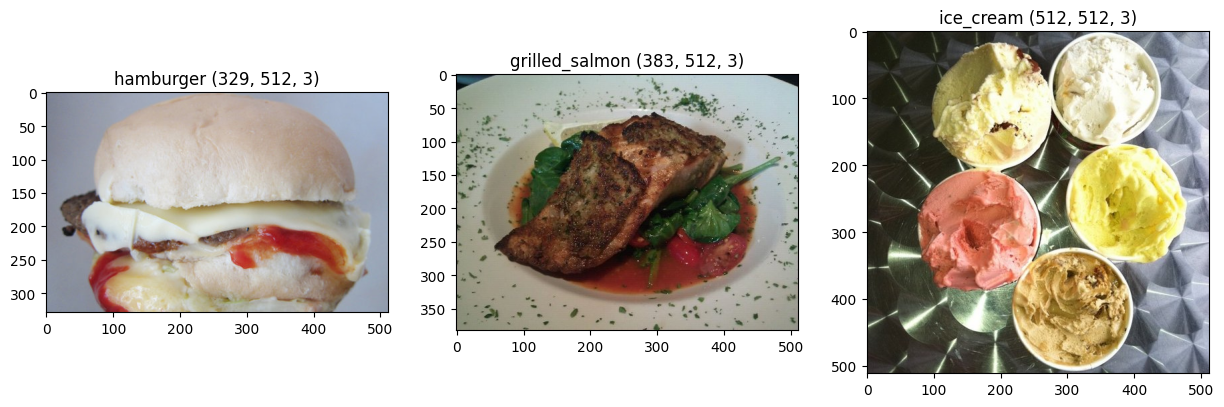

In [37]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15,7))
id = random.choice(range(0,749))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/hamburger')][id]
img = plt.imread('10_food_classes_all_data/train/hamburger/'+img_name)
plt.imshow(img)
plt.title('hamburger '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/grilled_salmon/')][id]
img = plt.imread('10_food_classes_all_data/train/grilled_salmon/'+img_name)
plt.imshow(img)
plt.title('grilled_salmon '+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/ice_cream/')][id]
img = plt.imread('10_food_classes_all_data/train/ice_cream/'+img_name)
plt.imshow(img)
plt.title('ice_cream '+str(img.shape));

In [38]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('10_food_classes_all_data/train/hamburger/')]
imagen_prueba = plt.imread('10_food_classes_all_data/train/hamburger/'+random.choice(lista_img_pizza)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (512, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


### Creamos la arquitectura CNN para multi-clasificación

In [39]:
import tensorflow as tf
print(f"Version: {tf.__version__}")

Version: 2.13.0


In [40]:
tf.random.set_seed(42)

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical') #Usamos categorical para referirnos a que son más de dos clases
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical') #'sparse'

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [41]:
images, etiquetas = train_batch[0]
etiquetas [:5] #ONE HOT ENCODER

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [42]:
#Creamos la red convolucional

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 flatten_5 (Flatten)         (None, 27040)            

In [43]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [44]:
model_1.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 31s 122ms/step - loss: 2.0913 - accuracy: 0.2431 - val_loss: 1.9238 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 30s 127ms/step - loss: 1.8588 - accuracy: 0.3529 - val_loss: 1.8801 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 29s 124ms/step - loss: 1.6411 - accuracy: 0.4393 - val_loss: 1.7608 - val_accuracy: 0.3864 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 29s 123ms/step - loss: 1.4120 - accuracy: 0.5311 - val_loss: 1.7902 - val_accuracy: 0.3952 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 33s 139ms/step - loss: 1.1431 - accuracy: 0.6248 - val_loss: 1.9563 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 28s 121ms/step - loss: 0.8943 - accuracy: 0.7116 - val_loss: 2.0019 - val_accuracy: 0.3696 - lr: 0.0010
Epoch 7/200
235/235 [=========================

### Evaluamos el modelo

In [45]:
model_1.evaluate(test_batch)

79/79 [==============================] - 6s 79ms/step - loss: 2.8427 - accuracy: 0.3904


[2.8427388668060303, 0.3903999924659729]

### Hacemos una predicción

In [46]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/10_food_classes_all_data/test/fried_rice/1023430.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0)

y_pred = model_1.predict(img_expanded)
print(y_pred) #Softmax

1/1 [==============================] - 0s 149ms/step
[[3.2399199e-04 7.3131152e-05 2.7586598e-02 9.0274611e-05 3.7594125e-04
  1.1358001e-01 8.4641141e-01 4.3306136e-04 5.2036816e-04 1.0605144e-02]]


In [47]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

0.99999994

In [48]:
tf.argmax(y_pred).numpy()

6

In [49]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ") #ARGMAX

La predicción para la imagen de pizza es: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 


In [50]:
y_pred = tf.argmax(y_pred) #argmax retorna el indice del item mayor de todos los items
print(f"La clase es: {classes[y_pred]}")

La clase es: chicken_wings


# Ejercicio 2

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,...)
2. El tamaño del kernel de los filtros también puede crecer.
3. Podemos implementar data augmentation (más tecnicas).
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

## Data augmentation

In [51]:
import tensorflow as tf
tf.random.set_seed(10)

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 horizontal_flip=True,
                                                                 vertical_flip=True)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical') #Usamos categorical para referirnos a que son más de dos clases
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical') #'sparse'

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Red Convolucional

In [52]:
#Creamos la red convolucional

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(20, kernel_size=(11,11), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(20, kernel_size=(11,11), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.05)),
    tf.keras.layers.Conv2D(20, kernel_size=(11,11), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 214, 214, 20)      7280      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 107, 107, 20)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 20)        48420     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 48, 48, 20)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 20)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 38, 38, 20)       

## Compilamos y entrenamos el modelo

In [53]:
# Compilamos
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00015),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Entrenamos
model_1.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_1', save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_1'),
                         tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/100
235/235 [==============================] - 38s 143ms/step - loss: 0.3190 - accuracy: 0.2007 - precision_2: 0.4215 - recall_2: 0.0136 - val_loss: 0.2972 - val_accuracy: 0.2700 - val_precision_2: 0.4888 - val_recall_2: 0.0348 - lr: 1.5000e-04
Epoch 2/100
235/235 [==============================] - 32s 135ms/step - loss: 0.2940 - accuracy: 0.2867 - precision_2: 0.4674 - recall_2: 0.0449 - val_loss: 0.2861 - val_accuracy: 0.3108 - val_precision_2: 0.5556 - val_recall_2: 0.0700 - lr: 1.5000e-04
Epoch 3/100
235/235 [==============================] - 33s 141ms/step - loss: 0.2856 - accuracy: 0.3149 - precision_2: 0.5157 - recall_2: 0.0744 - val_loss: 0.2808 - val_accuracy: 0.3352 - val_precision_2: 0.5535 - val_recall_2: 0.0848 - lr: 1.5000e-04
Epoch 4/100
235/235 [==============================] - 32s 136ms/step - loss: 0.2778 - accuracy: 0.3439 - precision_2: 0.5197 - recall_2: 0.1109 - val_loss: 0.2758 - val_accuracy: 0.3460 - val_precision_2: 0.6390 - val_recall_2: 0.1232 - lr:

## Evaluacion del modelo

In [54]:
model_1 = tf.keras.models.load_model('/content/checkpoints/model_1')
model_1.evaluate(test_batch)

79/79 [==============================] - 8s 92ms/step - loss: 0.2380 - accuracy: 0.4768 - precision_2: 0.6166 - recall_2: 0.3616


[0.2380310595035553,
 0.47679999470710754,
 0.6166439056396484,
 0.36160001158714294]

## Comparaciones

* Cantidad de filtros de capas convolucionales modificada de 10 a 20.
* Tamaño de kernel modificado de 3x3 a 11x11.
* Data augmentation extra implementada en test: horizontal_flip, vertical_flip.
* Dropout utilizado en la red profunda con un valor de 0.05.
* Learning rate modificado de 0.0001 a 0.00015.
### Resultados
* Score anterior: `loss: 2.8427 - accuracy: 0.3904`
* Score mejorado: `loss: 0.2380 - accuracy: 0.4768 - precision_2: 0.6166 - recall_2: 0.3616`



---



## 3. Transfer Learning

O también conocido cómo `fine tuning` es el método por el cual instanciamos una red neuronal convolucional previamente entrenada para otra tarea, pero sus filtros de más bajo nivel sirven para muchos propositos.

Nosotros tomamos esa CNN y re-entrenamos sus capas de más alto nivel para el objetivo que queremos lograr (por ejemplo clasificar comida en imágenes).

Para esto `keras` ya tiene implementado varios arquitecturas pre-entrenadas, las más conocidas son:

* AlexNet
* VGG 16
* VGG 19
* Inception
* ResNet
* EfficientNet


In [56]:
base_model = tf.keras.applications.VGG19(include_top=False, #sin la parte dnn
                                         weights='imagenet') #EfficienteNetB0
base_model.trainable = False

In [57]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x7b85413abd30>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b85413a99c0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84de399960>
3 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b85413aa9e0>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84bd648460>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b85081269e0>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b84bd4946d0>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84bd648c10>
8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84bd497c40>
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b85413a98a0>
10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84bd495f60>
11 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b84bd3ea560>
12 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b84bd3e9e10>
13 <keras.src.layer

In [58]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               6422784   
                                                                 
 dense_19 (Dense)            (None, 10)                2570      
                                                                 
Total params: 26449738 (100.90 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [59]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 63s 240ms/step - loss: 1.9347 - accuracy: 0.4055 - val_loss: 1.3216 - val_accuracy: 0.5588
Epoch 2/200
235/235 [==============================] - 53s 226ms/step - loss: 1.2730 - accuracy: 0.5764 - val_loss: 1.1467 - val_accuracy: 0.6064
Epoch 3/200
235/235 [==============================] - 51s 218ms/step - loss: 1.1184 - accuracy: 0.6327 - val_loss: 1.1758 - val_accuracy: 0.6024
Epoch 4/200
235/235 [==============================] - 52s 223ms/step - loss: 1.0162 - accuracy: 0.6613 - val_loss: 1.0575 - val_accuracy: 0.6416
Epoch 5/200
235/235 [==============================] - 53s 226ms/step - loss: 0.9435 - accuracy: 0.6852 - val_loss: 0.9944 - val_accuracy: 0.6632
Epoch 6/200
235/235 [==============================] - 51s 218ms/step - loss: 0.8801 - accuracy: 0.7003 - val_loss: 1.0844 - val_accuracy: 0.6324
Epoch 7/200
235/235 [==============================] - 52s 223ms/step - loss: 0.8046 - accuracy: 0.7319 - val_loss: 1.0430 -

In [61]:
model_2.evaluate(test_batch)

79/79 [==============================] - 13s 165ms/step - loss: 1.0809 - accuracy: 0.6772


[1.0808981657028198, 0.6772000193595886]

>**Nota:** Vemos que la implementación de la tecnica de `Transfer Learning` con un modelo pre-entrenado mejoro sustancialmente los valores de las métricas de evaluación.

# Ejercicio 3

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. Probar otras redes pre entrenadas convolucionales: ['ResNet101','EfficientNetB0','InceptionNet']

[Link](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

## Probamos con EfficientNetB0

In [62]:
import tensorflow as tf
tf.random.set_seed(15)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=True,
                                                               weights='imagenet',
                                                               input_tensor=None,
                                                               input_shape=None,
                                                               pooling=None,
                                                               classes=1000,
                                                               classifier_activation='softmax')

base_model.trainable = False

21834768/21834768 [==============================] - 0s 0us/step


## Red convolucional

In [63]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1000)              5330571   
 )                                                               
                                                                 
 flatten_8 (Flatten)         (None, 1000)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               256256    
                                                                 
 dense_21 (Dense)            (None, 10)                2570      
                                                                 
Total params: 5589397 (21.32 MB)
Trainable params: 258826 (1011.04 KB)
Non-trainable params: 5330571 (20.33 MB)
_________________________________________________________________


## Compilamos y entrenamos

In [64]:
# Compilamos
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Entrenamos
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_2', save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_2'),
                         tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 67s 258ms/step - loss: 2.3033 - accuracy: 0.0952 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 2.3026 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 59s 250ms/step - loss: 2.3028 - accuracy: 0.0884 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 2.3026 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 61s 260ms/step - loss: 2.3028 - accuracy: 0.0935 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 2.3026 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 33s 140ms/step - loss: 2.3028 - accuracy: 0.0957 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 2.3026 - val_accuracy: 0.1000 - val_prec

## Evaluamos el modelo

In [65]:
model_2 = tf.keras.models.load_model('/content/checkpoints/model_2')
model_2.evaluate(test_batch)

79/79 [==============================] - 10s 102ms/step - loss: 2.3026 - accuracy: 0.1000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00


[2.3025872707366943, 0.10000000149011612, 0.0, 0.0]

## Probamos con ResNet101

In [66]:
import tensorflow as tf
tf.random.set_seed(15)

base_model = tf.keras.applications.resnet.ResNet101(include_top=True,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=None,
                                                    pooling=None,
                                                    classes=1000)

base_model.trainable = False

179648224/179648224 [==============================] - 1s 0us/step


## Red convolucional

In [67]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 1000)              44707176  
                                                                 
 flatten_9 (Flatten)         (None, 1000)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               256256    
                                                                 
 dense_23 (Dense)            (None, 10)                2570      
                                                                 
Total params: 44966002 (171.53 MB)
Trainable params: 258826 (1011.04 KB)
Non-trainable params: 44707176 (170.54 MB)
_________________________________________________________________


## Compilamos y entrenamosss

In [68]:
# Compilamos
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Entrenamos
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_2', save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_2'),
                         tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 104s 407ms/step - loss: 2.3033 - accuracy: 0.0972 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3023 - val_accuracy: 0.1004 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 92s 390ms/step - loss: 2.3026 - accuracy: 0.1108 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3020 - val_accuracy: 0.1084 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 93s 394ms/step - loss: 2.3023 - accuracy: 0.1060 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3013 - val_accuracy: 0.1044 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 94s 398ms/step - loss: 2.3014 - accuracy: 0.1128 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3000 - val_accuracy: 0.1484 - val_pre

## Evaluamos el modelo

In [69]:
model_2 = tf.keras.models.load_model('/content/checkpoints/model_2')
model_2.evaluate(test_batch)

79/79 [==============================] - 16s 176ms/step - loss: 2.2323 - accuracy: 0.1644 - precision_4: 1.0000 - recall_4: 4.0000e-04


[2.2322630882263184, 0.16439999639987946, 1.0, 0.00039999998989515007]

## Probamos con InceptionResNetV2

In [70]:
import tensorflow as tf
tf.random.set_seed(15)

base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True,
                                                                         weights='imagenet',
                                                                         input_tensor=None,
                                                                         input_shape=None,
                                                                         pooling=None,
                                                                         classes=1000,
                                                                         classifier_activation='softmax')

base_model.trainable = False

225209952/225209952 [==============================] - 6s 0us/step


## Red convolucional

In [73]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([299,299,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1000)              55873736  
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 1000)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               256256    
                                                                 
 dense_27 (Dense)            (None, 10)                2570      
                                                                 
Total params: 56132562 (214.13 MB)
Trainable params: 258826 (1011.04 KB)
Non-trainable params: 55873736 (213.14 MB)
_________________________________________________________________


## Compilamos y entrenamoss

In [74]:
# Compilamos
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Entrenamos
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_2', save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_2'),
                         tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 134s 522ms/step - loss: 1.7645 - accuracy: 0.4687 - precision_6: 0.8466 - recall_6: 0.1177 - val_loss: 1.3490 - val_accuracy: 0.5528 - val_precision_6: 0.8063 - val_recall_6: 0.2864 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 122s 520ms/step - loss: 1.3927 - accuracy: 0.5196 - precision_6: 0.7706 - recall_6: 0.2889 - val_loss: 1.2898 - val_accuracy: 0.5468 - val_precision_6: 0.7875 - val_recall_6: 0.3276 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 124s 527ms/step - loss: 1.3511 - accuracy: 0.5288 - precision_6: 0.7534 - recall_6: 0.3227 - val_loss: 1.2712 - val_accuracy: 0.5572 - val_precision_6: 0.7788 - val_recall_6: 0.3296 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 125s 533ms/step - loss: 1.3147 - accuracy: 0.5428 - precision_6: 0.7580 - recall_6: 0.3359 - val_loss: 1.2492 - val_accuracy: 0.5644 - val_precision_6: 0.7537 - val_recall_6: 0.3844 - lr: 0.0010


## Evaluamos el modelo

In [75]:
model_2 = tf.keras.models.load_model('/content/checkpoints/model_2')
model_2.evaluate(test_batch)

79/79 [==============================] - 17s 169ms/step - loss: 1.1907 - accuracy: 0.5932 - precision_6: 0.7750 - recall_6: 0.4024


[1.1907178163528442,
 0.5932000279426575,
 0.7750385403633118,
 0.4023999869823456]

## Comparaciones
* Score de VGG 19: `loss: 1.0809 - accuracy: 0.6772`
* Score de EfficientNetB0: `loss: 2.3026 - accuracy: 0.1000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00`
* Score de ResNet101: `loss: 2.2323 - accuracy: 0.1644 - precision_4: 1.0000 - recall_4: 4.0000e-04`
* Score de InceptionResNetV2: `loss: 1.1907 - accuracy: 0.5932 - precision_6: 0.7750 - recall_6: 0.4024`

De los tres modelos, el que obtuvo un mejor resultado fue InceptionResNetV2.